# Python for Data 26: ANOVA
[back to index](https://www.kaggle.com/hamelg/python-for-data-analysis-index)

In lesson 24 we introduced the t-test for checking whether the means of two groups differ. The t-test works well when dealing with two groups, but sometimes we want to compare more than two groups at the same time. For example, if we wanted to test whether voter age differs based on some categorical variable like race, we have to compare the means of each level or group the variable. We could carry out a separate t-test for each pair of groups, but when you conduct many tests you increase the chances of false positives. The [analysis of variance](https://en.wikipedia.org/wiki/Analysis_of_variance) or ANOVA is a statistical inference test that lets you compare multiple groups at the same time.

# One-Way ANOVA

The one-way ANOVA tests whether the mean of some numeric variable differs across the levels of one categorical variable. It essentially answers the question: do any of the group means differ from one another? We won't get into the details of carrying out an ANOVA by hand as it involves more calculations than the t-test, but the process is similar: you go through several calculations to arrive at a test statistic and then you compare the test statistic to a critical value based on a probability distribution. In the case of the ANOVA, you use the "[f-distribution](https://en.wikipedia.org/wiki/F-distribution)".

The scipy library has a function for carrying out one-way ANOVA tests called scipy.stats.f_oneway(). Let's generate some fake voter age and demographic data and use the ANOVA to compare average ages across the groups:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
np.random.seed(12)

races =   ["asian","black","hispanic","other","white"]

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups

# Etract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

The test output yields an F-statistic of 1.774 and a p-value of 0.1317, indicating that there is no significant difference between the means of each group.

Another way to carry out an ANOVA test is to use the statsmodels library, which allows you to specify a model with a formula syntax that mirrors that used by the R programming language. R users may find this method more familiar:

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df         F    PR(>F)
race        199.369    4.0  1.774469  0.131732
Residual  27948.102  995.0       NaN       NaN


As you can see, the statsmodels method produced the same F statistic and P-value (listed as PR(<F)) as the stats.f_oneway method.

Now let's make new age data where the group means do differ and run a second ANOVA:

In [4]:
np.random.seed(12)

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Use a different distribution for white ages
white_ages = stats.poisson.rvs(loc=18, 
                              mu=32,
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race=="white", white_ages, voter_age)

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups   

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

In [5]:
# Alternate method
model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                sum_sq     df        F        PR(>F)
race       1284.123213    4.0  10.1647  4.561324e-08
Residual  31424.995787  995.0      NaN           NaN


The test result suggests the groups don't have the same sample means in this case, since the p-value is significant at a 99% confidence level. We know that it is the white voters who differ because we set it up that way in the code, but when testing real data, you may not know which group(s) caused the test to throw a positive result. To check which groups differ after getting a positive ANOVA result, you can perform a follow up test or "post-hoc test".

One post-hoc test is to perform a separate t-test for each pair of groups. You can perform a t-test between all pairs using by running each pair through the stats.ttest_ind() we covered in the lesson on t-tests:

In [6]:
# Get all race pairs
race_pairs = []

for race1 in range(4):
    for race2  in range(race1+1,5):
        race_pairs.append((races[race1], races[race2]))

# Conduct t-test on each pair
for race1, race2 in race_pairs: 
    print(race1, race2)
    print(stats.ttest_ind(voter_age[groups[race1]], 
                          voter_age[groups[race2]]))

asian black
Ttest_indResult(statistic=0.838644690974798, pvalue=0.4027281369339345)
asian hispanic
Ttest_indResult(statistic=-0.42594691924932293, pvalue=0.6704669004240726)
asian other
Ttest_indResult(statistic=0.9795284739636, pvalue=0.3298877500095151)
asian white
Ttest_indResult(statistic=-2.318108811252288, pvalue=0.020804701566400217)
black hispanic
Ttest_indResult(statistic=-1.9527839210712925, pvalue=0.05156197171952594)
black other
Ttest_indResult(statistic=0.28025754367057176, pvalue=0.7795770111117659)
black white
Ttest_indResult(statistic=-5.379303881281835, pvalue=1.039421216662395e-07)
hispanic other
Ttest_indResult(statistic=1.5853626170340225, pvalue=0.11396630528484335)
hispanic white
Ttest_indResult(statistic=-3.5160312714115376, pvalue=0.0004641298649066684)
other white
Ttest_indResult(statistic=-3.763809322077872, pvalue=0.00018490576317593065)


The p-values for each pairwise t-test suggest mean of white voters is likely different from the other groups, since the p-values for each t-test involving the white group is below 0.05. Using unadjusted pairwise t-tests can overestimate significance, however, because the more comparisons you make, the more likely you are to come across an unlikely result due to chance. We can adjust for this multiple comparison problem by dividing the statistical significance level by the number of comparisons made. In this case, if we were looking for a significance level of 5%, we'd be looking for p-values of 0.05/10 = 0.005 or less. This simple adjustment for multiple comparisons is known as the Bonferroni correction.

The Bonferroni correction is a conservative approach to account for the multiple comparisons problem that may end up rejecting results that are actually significant. Another common post hoc-test is Tukey's test. You can carry out Tukey's test using the pairwise_tukeyhsd() function in the statsmodels.stats.multicomp library:

group1,group2,meandiff,lower,upper,reject
asian,black,-0.8032,-3.4423,1.836,False
asian,hispanic,0.4143,-2.1011,2.9297,False
asian,other,-1.0645,-4.2391,2.11,False
asian,white,1.9547,-0.4575,4.3668,False
black,hispanic,1.2175,-0.386,2.821,False
black,other,-0.2614,-2.7757,2.253,False
black,white,2.7579,1.3217,4.194,True
hispanic,other,-1.4789,-3.863,0.9053,False
hispanic,white,1.5404,0.3468,2.734,True
other,white,3.0192,0.7443,5.2941,True


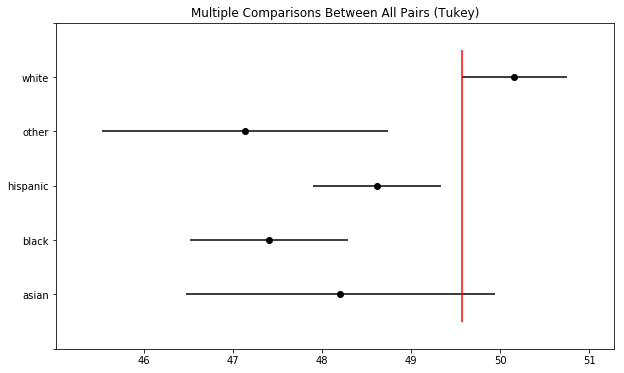

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age,     # Data
                          groups=voter_race,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

The output of the Tukey test shows the average difference, a confidence interval as well as whether you should reject the null hypothesis for each pair of groups at the given significance level. In this case, the test suggests we reject the null hypothesis for 3 pairs, with each pair including the "white" category. This suggests the white group is likely different from the others. The 95% confidence interval plot reinforces the results visually: only 1 other group's confidence interval overlaps the white group's confidence interval.

# Wrap Up

The ANOVA test lets us check whether a numeric response variable varies according to the levels of a categorical variable. Python's scipy library makes it easy to perform an ANOVA without diving too deep into the details of the procedure.

Next time, we'll move on from statistical inference to the final topic of this guide: predictive modeling.

# Next Lesson: [Python for Data 27: Linear Regression](https://www.kaggle.com/hamelg/python-for-data-27-linear-regression)
[back to index](https://www.kaggle.com/hamelg/python-for-data-analysis-index)